<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 2) Investigating Embedding Vector Length in a Recommender System</b><br>
In a recommender system example, determine the appropriate length of the embedding vector by plotting a graph of length versus accuracy and analyzing it. Use any of the three codes you deem suitable.
</div>

In [8]:
!wget -q https://github.com/Alireza-Akhavan/datasets_and_models/raw/main/ratings.csv

!head -n 1 ratings.csv > header.csv
!tail -n +2 ratings.csv > temp.csv

!shuf temp.csv > shuffled.csv

!wc -l < shuffled.csv

!split -l $(( 981756 * 80 / 100 )) shuffled.csv

# Rename the split files to indicate train and test sets
!cat header.csv xaa >  train_data.csv
!cat header.csv xab >  test_data.csv

!rm header.csv shuffled.csv temp.csv xaa xab

981756


In [29]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

In [18]:
def create_dataset(filename):
    record_defaults = [tf.int64, tf.int64, tf.int32]
    dataset = tf.data.experimental.CsvDataset(filename, record_defaults, header=True)
    dataset = dataset.map(lambda *x: ((x[0], x[1]), x[2]))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(512)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [19]:
data = create_dataset('ratings.csv')
train = create_dataset('train_data.csv')
test = create_dataset('test_data.csv')

In [20]:
unique_books = set()
unique_users = set()

for (users, books), _ in data:
    for user, book in zip(users.numpy(), books.numpy()):
        unique_books.add(book)
        unique_users.add(user)

n_books = len(unique_books)
n_users = len(unique_users)

print(f"Number of unique books: {n_books}")
print(f"Number of unique users: {n_users}")

Number of unique books: 53424
Number of unique users: 10000


In [25]:
models = dict([])

for i in range(5,18):
  book_input = tf.keras.layers.Input(shape=[1], name="Book-Input")
  book_embedding = tf.keras.layers.Embedding(n_books+1, i, name="Book-Embedding")(book_input)
  book_vec = tf.keras.layers.Flatten(name="Flatten-Books")(book_embedding)

  user_input = tf.keras.layers.Input(shape=[1], name="User-Input")
  user_embedding = tf.keras.layers.Embedding(n_users+1, i, name="User-Embedding")(user_input)
  user_vec = tf.keras.layers.Flatten(name="Flatten-Users")(user_embedding)

  concat = tf.keras.layers.Concatenate(name="Concatenate")([book_vec, user_vec])
  Dense1 = tf.keras.layers.Dense(10, activation='relu')(concat)
  drop = tf.keras.layers.Dropout(0.5)(Dense1)
  out = tf.keras.layers.Dense(1)(drop)

  models[i] = tf.keras.models.Model([user_input, book_input], out)
  models[i].compile('adam', 'mean_squared_error')

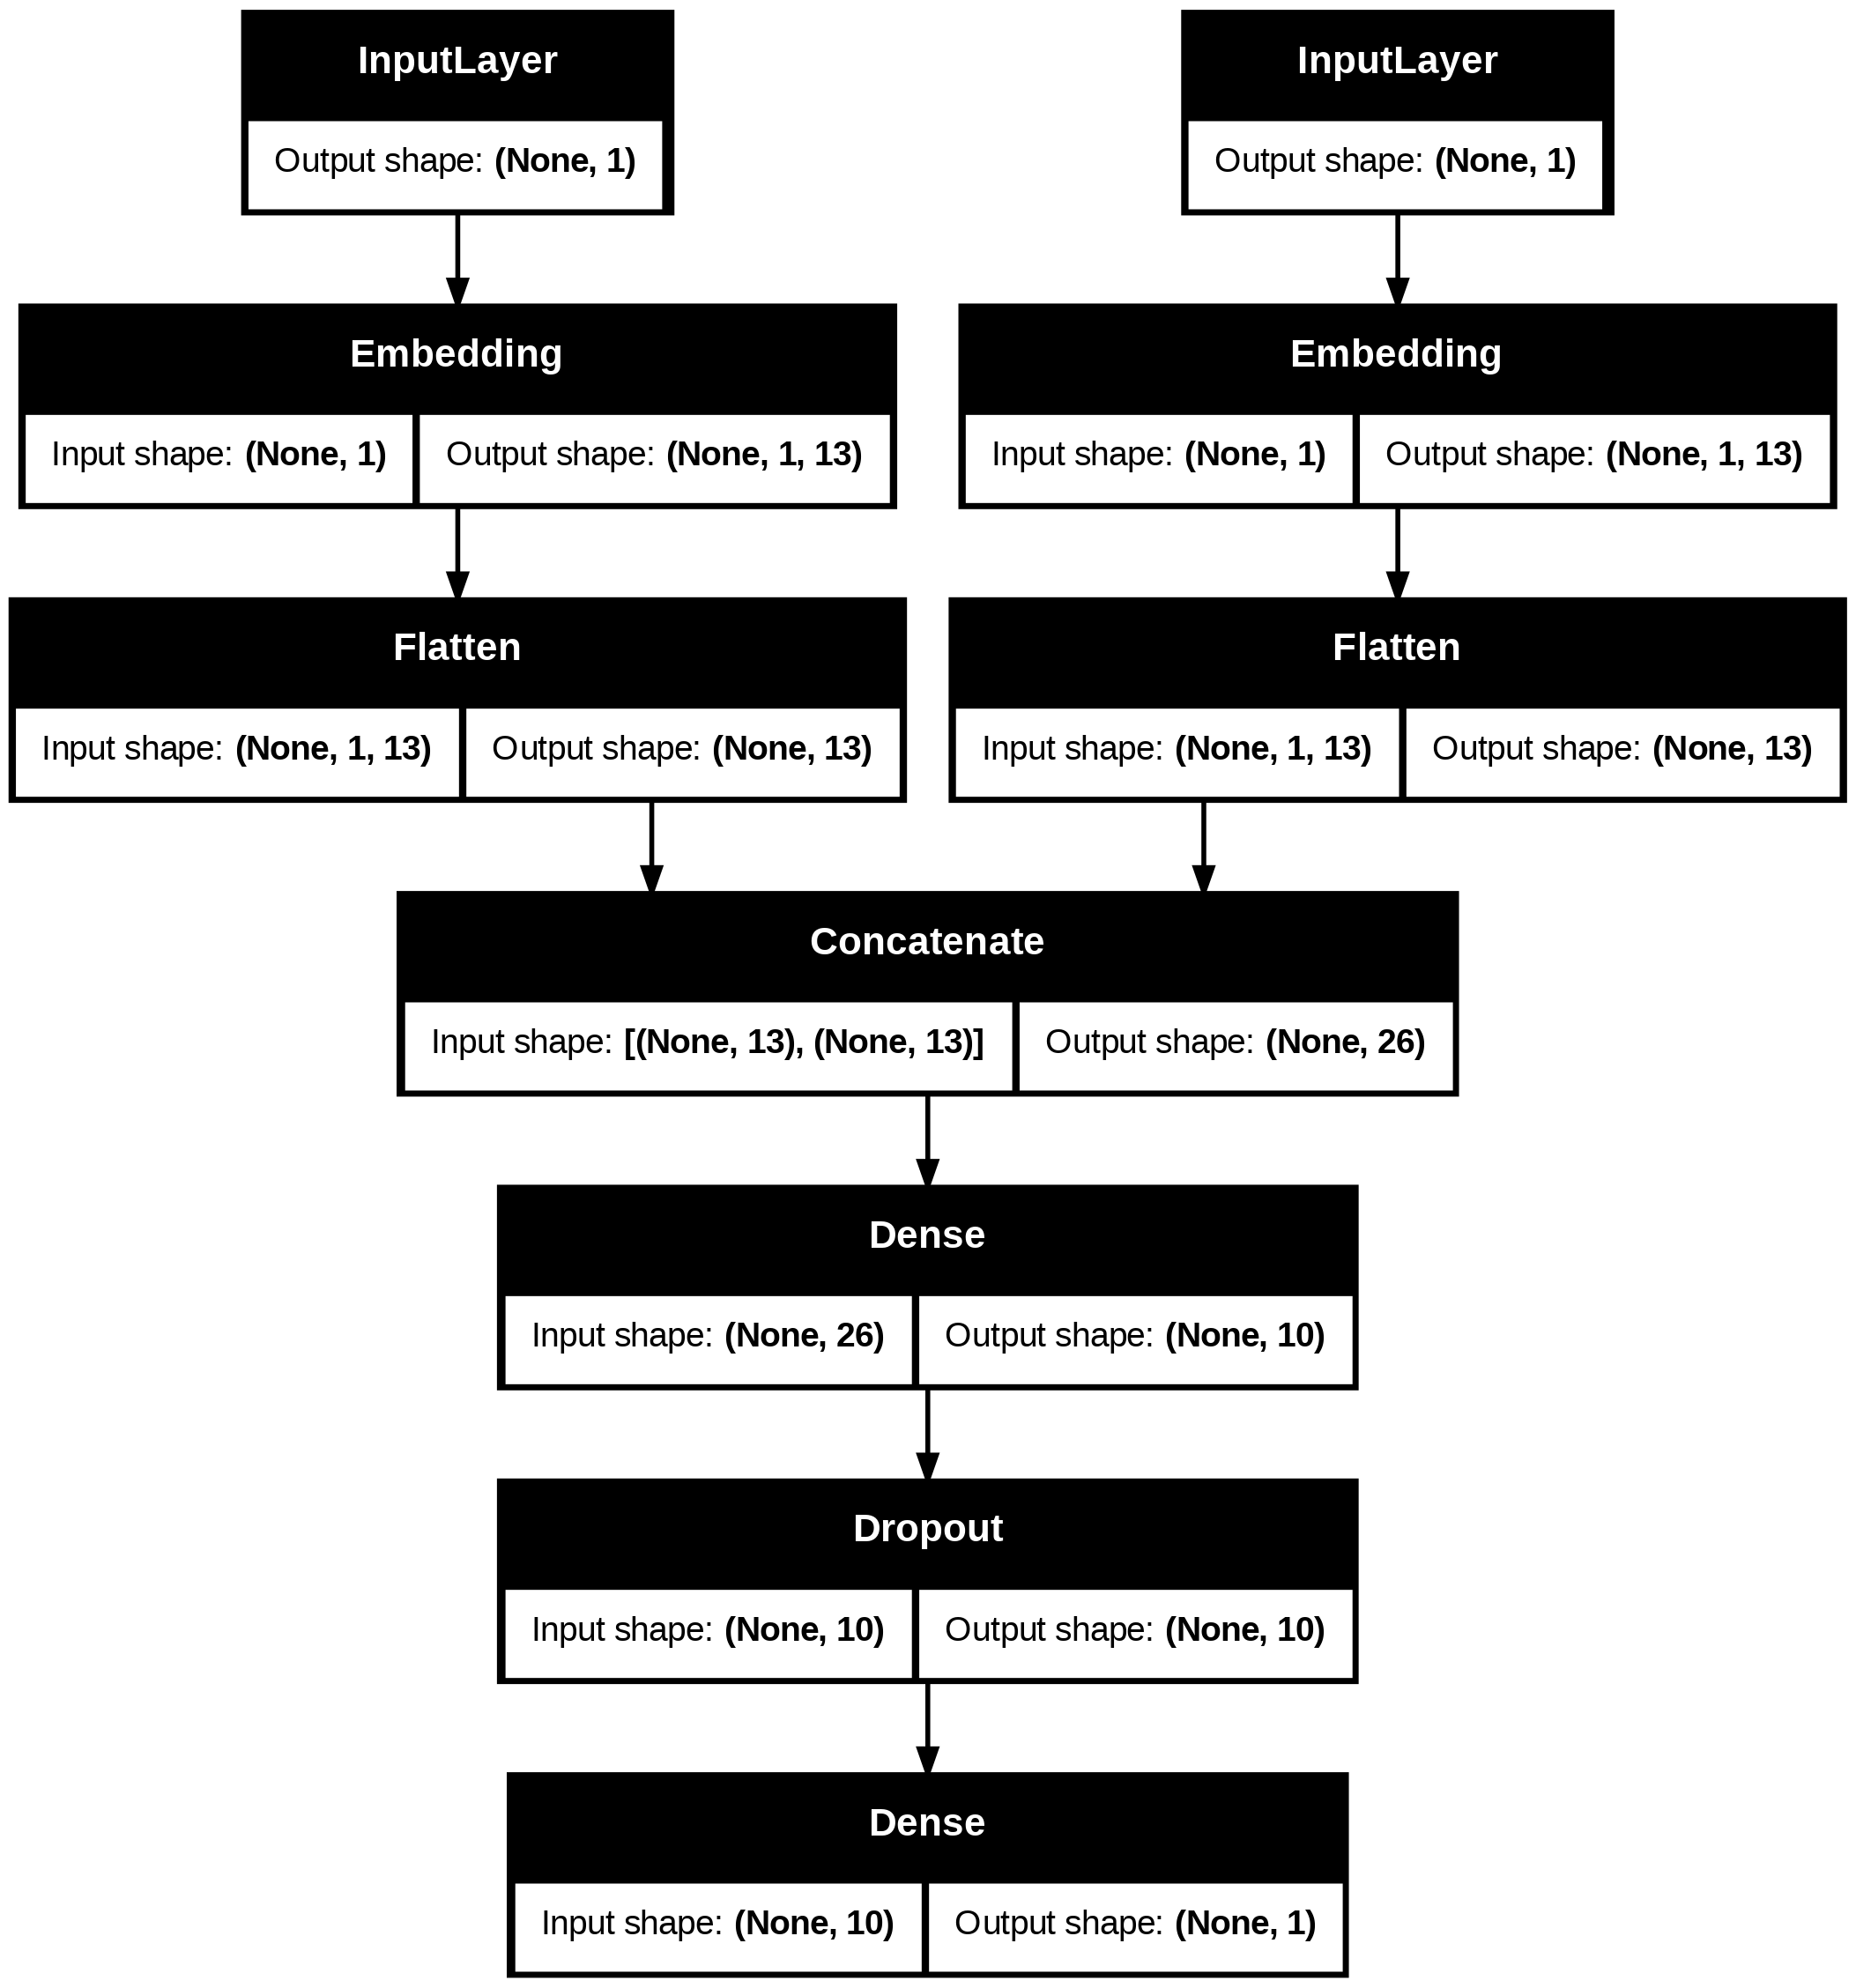

In [26]:
keras.utils.plot_model(models[13], show_shapes=True)

In [23]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

histories = dict([])

for i in range(5, 18):

  early_stopping = EarlyStopping(
      monitor='val_loss',
      patience=7,
      verbose=1,
      restore_best_weights=True
  )

  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=4,
      verbose=1,
      min_lr=1e-7
  )


  histories[i] = models[i].fit(train, epochs=30,
                               callbacks=[early_stopping,reduce_lr],
                               validation_data=test,
                              #  verbose=0
                               )
  print(f'training model_{i} done.')

Epoch 1/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7.7465 - val_loss: 1.1488 - learning_rate: 0.0010
Epoch 2/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.4373 - val_loss: 0.9157 - learning_rate: 0.0010
Epoch 3/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.4975 - val_loss: 0.7843 - learning_rate: 0.0010
Epoch 4/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9441 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 5/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7417 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 6/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7043 - val_loss: 0.7119 - learning_rate: 0.0010
Epoch 7/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6951 - val_loss: 0.7107 - learning_rate: 0.0010
Epoch 8/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6892 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 9/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6822 - val_loss: 0.7100 - learning_rate

KeyError: 16

we trained 15 models

In [30]:
best_val_losses=[]

for i in range(5,16):
  val_loss_history = histories[i].history['val_loss']
  best_epoch_index = np.argmin(val_loss_history)
  best_val_loss = val_loss_history[best_epoch_index]
  best_val_losses.append(best_val_loss)

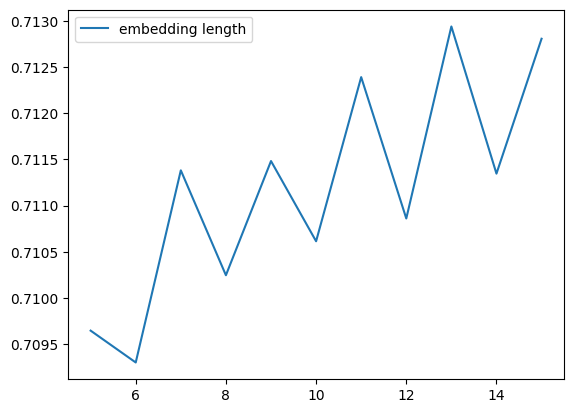

In [31]:
plt.plot(np.arange(5,16), np.array(best_val_losses))
plt.legend(["embedding length", "loss"])

It seems that increasing the length of the embedding vector does not improve the conditions, and the error does not decrease; it may even increase. The best model with an embedding size of 6 has the lowest error. Therefore, it appears that an embedding size of 6 is the best option.

In any case, changing the size of the embedding vector does not seem to play a significant role in the amount of error, and its impact is in the order of hundredths.